## Analyze low-input bulk RNA-seq data obtained from fixed and intracellularly stained RA synovial fluid CD8 T cells sorted for GzmK and GzmB expression.

In [2]:
# Load dependencies 
library(gridExtra)
library(cowplot)
require(scales)
library(matrixStats)
library(viridis)
library(patchwork)
library(limma)
library(pbapply)
library(parallel)
library(ggrepel)
library(limma)
library(Rtsne)
library(harmony)
library(magrittr)
library(ggthemes)
library(reticulate)
library(plyr)
library(ggplot2)
library(dplyr)
library(RColorBrewer)
library(ggbeeswarm)
library(MASS)
library(grid)
library(umap)
library(stringr)
library(data.table)
require(gdata)
library(tximport)
library(readr)
library(biomaRt)
library(farver)
library(ggpubr)
library(tidyverse)
library(rstatix)

meta_colors <- list(
        
  "marker" = c(
        "GzmBplus" = "#084594", 
        "GzmKplus" = "#FFD92F",
        "GzmKplusBplus" = "#74C476", 
        "Gzm" = "#999999"
    )
)

In [3]:
FindVariableGenesBatch <- function(exprs_mat, meta_df, cell_col = "cell_id",
                                   batch_col = "sample_id", ngenes_use = 1e3, expr_min = .1) {
    x_res <- split(meta_df[[cell_col]], meta_df[[batch_col]]) %>% lapply(function(x) {
        FindVariableGenesSeurat(exprs_mat[, x]) %>%
            subset(gene.mean >= expr_min) %>%
            tibble::rownames_to_column("gene") %>%
            dplyr::arrange(-gene.dispersion) %>%
            head(ngenes_use)
    })
    data.table(Reduce(rbind, x_res))[, .N, by = gene][order(-N)]
}

FindVariableGenesBatch <- function(exprs_mat, meta_df, genes_exclude = NULL, ngenes_use = 1e3, expr_min = .1) {
    if (!is.null(genes_exclude)) {
        genes_use <- setdiff(row.names(exprs_mat), genes_exclude)
    }
    x_res <- split(meta_df$cell, meta_df$sample) %>% lapply(function(x) {
        FindVariableGenesSeurat(exprs_mat[genes_use, x]) %>% 
            subset(gene.mean >= expr_min) %>% 
            tibble::rownames_to_column("gene") %>% 
            dplyr::arrange(-gene.dispersion) %>%
            head(ngenes_use)
    })
    data.table(Reduce(rbind, x_res))[, .N, by = gene][order(-N)]    
}



FindVariableGenesSeurat <- function (data, x.low.cutoff = 0.1, x.high.cutoff = 8,
                                     y.cutoff = 1, y.high.cutoff = Inf, num.bin = 0,
                                     binning.method = "equal_width", sort.results = TRUE,
                                     display.progress = TRUE, ...)
{
    genes.use <- rownames(data)
    if (class(data) != "dgCMatrix") {
        data <- as(as.matrix(data), "dgCMatrix")
    }
    ## (1) get means and variances
    gene.mean <- FastExpMean(data, display.progress)
    names(gene.mean) <- genes.use
    gene.dispersion <- FastLogVMR(data, display.progress)
    names(gene.dispersion) <- genes.use

    gene.dispersion[is.na(x = gene.dispersion)] <- 0
    gene.mean[is.na(x = gene.mean)] <- 0

    mv.df <- data.frame(gene.mean, gene.dispersion)
    rownames(mv.df) <- rownames(data)

    ## (OPTIONAL) do the binning correction
    if (num.bin > 0) {
      if (binning.method == "equal_width") {
          data_x_bin <- cut(x = gene.mean, breaks = num.bin)
      }
      else if (binning.method == "equal_frequency") {
          data_x_bin <- cut(x = gene.mean, breaks = c(-1, quantile(gene.mean[gene.mean >
              0], probs = seq(0, 1, length.out = num.bin))))
     }
      else {
          stop(paste0("Invalid selection: '", binning.method,
              "' for 'binning.method'."))
      }
      names(x = data_x_bin) <- names(x = gene.mean)
      mean_y <- tapply(X = gene.dispersion, INDEX = data_x_bin,
          FUN = mean)
      sd_y <- tapply(X = gene.dispersion, INDEX = data_x_bin,
          FUN = sd)
      gene.dispersion.scaled <- (gene.dispersion - mean_y[as.numeric(x = data_x_bin)])/sd_y[as.numeric(x = data_x_bin)]
      gene.dispersion.scaled[is.na(x = gene.dispersion.scaled)] <- 0
      ##names(gene.dispersion.scaled) <- names(gene.mean)

      mv.df$gene.dispersion.scaled <- gene.dispersion.scaled
    }

    return(mv.df)
}


BuildSNNSeurat <- function (data.use, k.param = 30, prune.SNN = 1/15, nn.eps = 0) {
    my.knn <- nn2(data = data.use, k = k.param, searchtype = "standard", eps = nn.eps)
    nn.ranked <- my.knn$nn.idx

    snn_res <- ComputeSNN(nn_ranked = nn.ranked, prune = prune.SNN)
    rownames(snn_res) <- row.names(data.use)
    colnames(snn_res) <- row.names(data.use)
    return(snn_res)
}
environment(BuildSNNSeurat) <- asNamespace("Seurat")

# Overwrite default draw_colnames in the pheatmap package.
# Thanks to Josh O'Brien at http://stackoverflow.com/questions/15505607
draw_colnames_45 <- function (coln, gaps, ...) {
    coord <- pheatmap:::find_coordinates(length(coln), gaps)
    x     <- coord$coord - 0.5 * coord$size
    res   <- grid::textGrob(
      coln, x = x, y = unit(1, "npc") - unit(3,"bigpts"),
      vjust = 0.75, hjust = 1, rot = 45, gp = grid::gpar(...)
    )
    return(res)
}
assignInNamespace(
  x = "draw_colnames",
  value = "draw_colnames_45",
  ns = asNamespace("pheatmap")
)

## Preprocessing

In [4]:
# Collate all of the Kallisto output files.
files <- Sys.glob(
  "/data/srlab1/fzhang/results/2020_amp2_lowinput_kallisto/output/*/abundance.h5"
)
files[1:4]
names(files) <- sapply(stringr::str_split(files, "/"), "[[", 8)
files[1:4]

In [5]:
genes <- read.delim("/data/srlab/public/srcollab/AMP/amp_phase1_ra/validation_data/Homo_sapiens.GRCh38.cdna.lincrna.filtered.genes.tsv.gz", header = T, stringsAsFactors = F)
genes <- genes[, c(1,2)]
genes$transcript_id <- str_replace(genes$transcript_id, "\\.\\d+$", "")
genes[1:4, ]

In [6]:
genes_tsv <- "/data/srlab/public/srcollab/AMP/amp_phase1_ra/validation_data/Homo_sapiens.GRCh38.cdna.lincrna.filtered.genes.tsv.gz"

if (!file.exists(genes_tsv)) {
  # Convert Ensembl IDs to HGNC gene symbols.
  mart <- useDataset("hsapiens_gene_ensembl", useMart("ensembl"))

  bm <- getBM(
    filters    = "ensembl_gene_id",
    attributes = c("ensembl_gene_id","hgnc_symbol"),
    values     = genes$gene_id,
    mart       = mart
  )

  x <- merge(
    x    = genes,
    y    = bm,
    by.x = "gene_id",
    by.y = "ensembl_gene_id",
    all  = TRUE
  )

  write_tsv(x, genes_tsv)
}

In [7]:
# Read files and collapse to gene level.
txi <- tximport(files, type = "kallisto", tx2gene = genes)

In [ ]:
# Save the whole object.
saveRDS(txi, "validation_data_ensembl83_txi.rds")

In [ ]:
bulk <- readRDS("./collated_output/CD8_data_ensembl83_txi_fixed.rds")
genes <- read.delim("/data/srlab/public/srcollab/AMP/amp_phase1_ra/validation_data/Homo_sapiens.GRCh38.cdna.lincrna.filtered.genes.tsv.gz", header = T, stringsAsFactors = F)

In [9]:
tpm_to_log2tpm <- function(x) log(x + 1)
log2tpm <- apply(as.data.frame(bulk$abundance), 2, tpm_to_log2tpm)
# log2tpm[c(39680:39689),]
"ENSG00000271503" %in% rownames(log2tpm)
dim(log2tpm)

[1] TRUE

[1] 65969    12

In [10]:
overlap_gene <- intersect(rownames(log2tpm), genes$gene_id)
length(overlap_gene)
log2tpm <- log2tpm[which(rownames(log2tpm) %in% overlap_gene),]
genes <- genes[which(genes$gene_id %in% overlap_gene),]
dim(log2tpm)
dim(genes)
all(rownames(log2tpm) == genes$gene_id)

[1] 41518

[1] 41518    12

[1] 41518     3

[1] TRUE

In [11]:
rownames(log2tpm) <- genes$hgnc_symbol

In [15]:
dim(log2tpm)
log2tpm[1:4,1:4]

[1] 41518    12

,P012_SF_CD8_GzmBplus_AHJ6578_S2,P012_SF_CD8_GzmKplus_AHJ6578_S1,P012_SF_CD8_GzmKplusBplus_AHJ6578_S3,P012_SF_CD8_Gzm_neg_AHJ6578
TSPAN6,1.2727336,0.3558405,1.3832171,1.7556306
TNMD,0.1292644,0.0000000,0.1465579,0.6691874
DPM1,2.9501767,3.4208127,3.4019390,2.9520447
SCYL3,2.6060239,2.8987273,2.7056189,2.6636008


In [16]:
"CCL5" %in% rownames(log2tpm)

[1] TRUE

In [6]:
# # Save the data
# write.table(log2tpm, file = paste("bulk_log2tpm", ".tsv", sep = ""),
#             row.names=T,col.names=T, quote = F, sep = "\t")

# write.table(cd, file = paste("bulk_counts", ".tsv", sep = ""),
#             row.names=T,col.names=T, quote = F, sep = "\t")

In [22]:
temp <- str_split(colnames(log2tpm), "_")
temp[[1]]

temp <- as.data.frame(temp)
colnames(temp) <- colnames(log2tpm)

meta = data.frame(
    Sample.ID = as.character(t(temp[1,])),
    marker = as.character(t(temp[4,]))
#     sort_day = as.character(t(temp[6,]))
)

# P012 was sorted on Jan 17th, and P028 and P033 were sorted on Jan 18th.  
# I performed the RNA extraction on the same day as the sorting, so that process was also technically two batches.

meta$sort_day <- c(rep("1", 4), rep("2", 8))
meta

[1] "P012"     "SF"       "CD8"      "GzmBplus" "AHJ6578"  "S2"

Sample.ID,marker,sort_day
<fct>,<fct>,<chr>
P012,GzmBplus,1
P012,GzmKplus,1
P012,GzmKplusBplus,1
P012,Gzm,1
P028,GzmBplus,2
P028,GzmKplus,2
P028,GzmKplusBplus,2
P028,Gzm,2
P033,GzmBplus,2


In [19]:
# meta = data.frame(
#     key = sub(".*20190322_ *(.*?) *(.*?) *_AHJ6578.* *(.*?) *_R1_001.*", "\\1", colnames(log2tpm))
# )
# meta$Sample.ID = gsub( "_.*$", "", meta$key)
# meta$marker = sub('.*\\_', '', meta$key)
# meta$sort_day <- c(rep("1", 4), rep("2", 8))
# meta

key,Sample.ID,marker,sort_day
<fct>,<chr>,<chr>,<chr>
P012_SF_CD8_GzmBplus_AHJ6578_S2,P012,S2,1
P012_SF_CD8_GzmKplus_AHJ6578_S1,P012,S1,1
P012_SF_CD8_GzmKplusBplus_AHJ6578_S3,P012,S3,1
P012_SF_CD8_Gzm_neg_AHJ6578,P012,AHJ6578,1
P028_SF_CD8_GzmBplus_AHJ6578_S6,P028,S6,2
P028_SF_CD8_GzmKplus_AHJ6578_S5,P028,S5,2
P028_SF_CD8_GzmKplusBplus_AHJ6578_S7,P028,S7,2
P028_SF_CD8_Gzm_neg_AHJ6578,P028,AHJ6578,2
P033_SF_CD8_GzmBplus_AHJ6578_S10,P033,S10,2


In [18]:
# `limma::removeBatchEffects()`
# just subtract the difference in means between donors, so the donor means are identical
log2tpm <- removeBatchEffect(x = log2tpm, batch = as.character(meta$Sample.ID), batch2 = as.character(meta$sort_day))
log2tpm[1:4,1:4]
dim(log2tpm)

Coefficients not estimable: batch21 


Warning message:
“Partial NA coefficients for 41518 probe(s)”

,P012_SF_CD8_GzmBplus_AHJ6578_S2,P012_SF_CD8_GzmKplus_AHJ6578_S1,P012_SF_CD8_GzmKplusBplus_AHJ6578_S3,P012_SF_CD8_Gzm_neg_AHJ6578
TSPAN6,1.136840,0.21994675,1.2473234,1.619737
TNMD,0.152139,0.02287453,0.1694325,0.692062
DPM1,2.780639,3.25127471,3.2324010,2.782507
SCYL3,2.609727,2.90243052,2.7093221,2.667304


[1] 41518    12

In [8]:
# Save the data
write.table(log2tpm, file = paste("bulk_kallisto_log2tpm_corrected_2019-12-20", ".tsv", sep = ""),
            row.names=T,col.names=T, quote = F, sep = "\t")
saveRDS(log2tpm, "bulk_kallisto_log2tpm_corrected_2019-12-20.rds")

## QC and downstream analysis

In [8]:
# Which genes are detected in 95% of samples? (# of non-zeros in log2tpm/ total # of samples)
nonzero_markers <- apply(log2tpm, 1, function(x) length(x[x>0])/length(x) > 0.9)
nonzero_genes <- log2tpm[nonzero_markers,]
common_genes <- rownames(nonzero_genes)
length(common_genes)
                         
# For a given sample, how many common genes are detected? (# of non-zeros in the common genes per sample/ total # of genes)
# If < 99%, that would be a BAD sample.
temp<-which(log2tpm[,1]>0)
common_index<-which(nonzero_markers, arr.ind=TRUE)

percentage <- array(0,dim=c(ncol(log2tpm)))
num_genes_det <- array(0,dim=c(ncol(log2tpm)))
  
for (i in 1:ncol(log2tpm)){
  temp<-which(log2tpm[,i]>0)
  num_genes_det[i] <- length(temp)
  inter<- intersect(common_index, temp)
  per<-length(inter)/length(common_genes)
  #print(per)
  percentage[i] <- per
}
                         
meta$percentage <- as.numeric(percentage)
meta

[1] 29455

Sample.ID,marker,sort_day,percentage
P012,GzmBplus,1,0.9846885
P012,GzmKplus,1,0.9110508
P012,GzmKplusBplus,1,0.9941945
P012,Gzm,1,0.9963673
P028,GzmBplus,2,0.9954167
P028,GzmKplus,2,0.9987099
P028,GzmKplusBplus,2,0.9970463
P028,Gzm,2,0.9964692
P033,GzmBplus,2,0.9967408
P033,GzmKplus,2,0.9608216


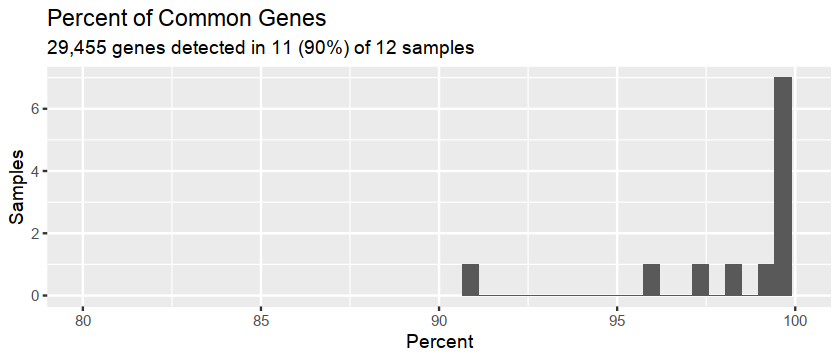

In [10]:
options(repr.plot.width = 7, repr.plot.height = 3)

ggplot(meta, aes(x = 100 * percentage)) +
geom_histogram(bins = 20) +
scale_y_continuous(breaks = scales::pretty_breaks(4)) +
coord_cartesian(xlim=c(80,100)) +
labs(
  x = "Percent", y = "Samples", title = "Percent of Common Genes",
  subtitle = sprintf(
    "%s genes detected in %s (90%%) of %s samples",
    comma(length(common_genes)), ceiling(nrow(meta) * 0.9), nrow(meta)
  )
)
# ggsave("qc.png", width = 5, height = 3, dpi = 300)

In [11]:
gene_summary <- data.frame(
  mean    = rowMeans(log2tpm),
  sd      = rowSds(log2tpm),
  samples = rowSums(log2tpm > 0),
  gene = rownames(log2tpm)
)
gene_summary$mean_quantile <- rank(gene_summary$mean) / nrow(gene_summary)
gene_summary$sd_quantile   <- rank(gene_summary$sd) / nrow(gene_summary)
gene_summary$density       <- with(gene_summary, get_density(mean, sd))

# ix_na <- is.na(gene_summary$gene)
# gene_summary$gene[ix_na] <- gene_summary$ensembl_id[ix_na]

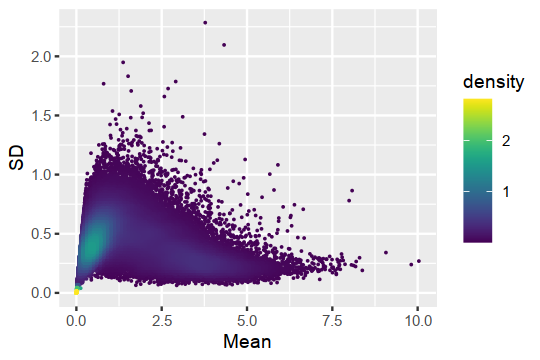

In [12]:
options(repr.plot.width = 4.5, repr.plot.height = 3)
ggplot(gene_summary[order(gene_summary$density),], aes(mean, sd, color = density)) +
scale_color_viridis() +
geom_point(size = 0.01) +
labs(x = "Mean", y = "SD")

Warning message:
"Transformation introduced infinite values in continuous x-axis"Warning message:
"Removed 3429 rows containing non-finite values (stat_bin)."

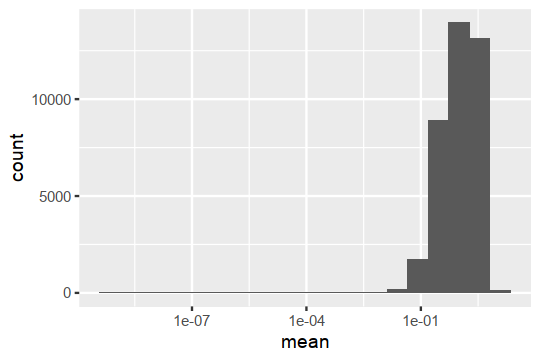

In [13]:
options(repr.plot.width = 4.5, repr.plot.height = 3)
ggplot(gene_summary, aes(x = mean)) +
geom_histogram(bins = 20) +
# geom_vline(xintercept = quantile(gene_summary$mean, 0.5), size = 0.2, color = 'red') +
scale_x_log10()

## PCA

In [17]:
ix_gene_mean <- gene_summary$mean > quantile(gene_summary$mean, 0.96)
ix_gene_sd <- gene_summary$sd > quantile(gene_summary$sd, 0.99)
scale_rows <- function(x) t(scale(t(x)))

temp <- log2tpm[ix_gene_mean,]
dim(temp) 
genes_exclude <- grep("^MT-|^RPL|^RPS|MALAT1|MIR-", row.names(log2tpm), value = TRUE)
temp <- temp[-which(rownames(temp) %in% genes_exclude),]
dim(temp)

pca <- summary(prcomp(
  x = scale_rows(temp),
  center = TRUE,
  scale = TRUE
))
meta <- cbind.data.frame(meta, pca$rotation[,1:11])
pca_var_labs <- sprintf(
  "PC%s, %.02g%% of variance",
  variance_explained(pca)$Component,
  100 * variance_explained(pca)$Variance
)
meta[1:4,]

[1] 1661   12

[1] 1563   12

,Sample.ID,marker,sort_day,percentage,gene,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
P012_SF_CD8_GzmBplus_AHJ6578_S2,P012,GzmBplus,1,0.9846885,3.389173,-0.1332569,0.44435187,-0.2434954,0.03526035,-0.47029868,0.3918364,-0.037134560,-0.2134246,-0.2414142,0.3227801,0.3740360
P012_SF_CD8_GzmKplus_AHJ6578_S1,P012,GzmKplus,1,0.9110508,4.578718,-0.3641039,-0.20714053,0.2221819,-0.31844059,0.11366797,-0.4957212,0.171327384,-0.2522781,-0.1745211,0.3526435,0.4086416
P012_SF_CD8_GzmKplusBplus_AHJ6578_S3,P012,GzmKplusBplus,1,0.9941945,3.602918,0.1519473,0.05316879,0.4332400,0.44569609,0.48539426,0.3342635,-0.003469351,-0.1619615,0.2182843,0.2664631,0.3087762
P012_SF_CD8_Gzm_neg_AHJ6578,P012,Gzm,1,0.9963673,3.707633,0.3675753,-0.23737590,-0.3234259,-0.05010627,-0.04947177,-0.1143605,-0.133378250,0.5643491,0.2282626,0.3561806,0.4127404


In [10]:
meta <- readRDS("pca_bulk_2019_04_30.rds")
dim(meta)
meta[1:4,]

[1] 12 16

,key,Sample.ID,marker,sort_day,percentage,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,gene
,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20190322_P012_SF_CD8_GzmBplus_AHJ6578_S2_R1_001,P012_SF_CD8_GzmBplus,P012,GzmBplus,1,0.9768476,-0.10441053,0.4801896,-0.1711818,0.3510359,-0.19188157,0.4721637,0.27329457,-0.01507179,0.14240699,-0.3461830,0.9031449
20190322_P012_SF_CD8_GzmKplusBplus_AHJ6578_S3_R1_001,P012_SF_CD8_GzmKplusBplus,P012,GzmKplusBplus,1,0.9908873,0.01853267,-0.0352123,0.3725218,-0.4865375,-0.59728055,-0.2293058,0.12825795,-0.02884367,-0.05917544,-0.3033977,0.8453906
20190322_P012_SF_CD8_GzmKplus_AHJ6578_S1_R1_001,P012_SF_CD8_GzmKplus,P012,GzmKplus,1,0.8612165,-0.33868268,-0.1736374,0.1389483,-0.1700771,0.64862192,-0.1145009,0.08002117,-0.25236019,0.21712386,-0.3494944,0.2254070
20190322_P012_SF_CD8_Gzm_neg_AHJ6578_S4_R1_001,P012_SF_CD8_Gzm_neg,P012,neg,1,0.9932854,0.39323639,-0.2505493,-0.2702489,0.2259019,0.05533121,-0.1422684,-0.42651436,0.26983565,-0.28320389,-0.3786274,1.3993026


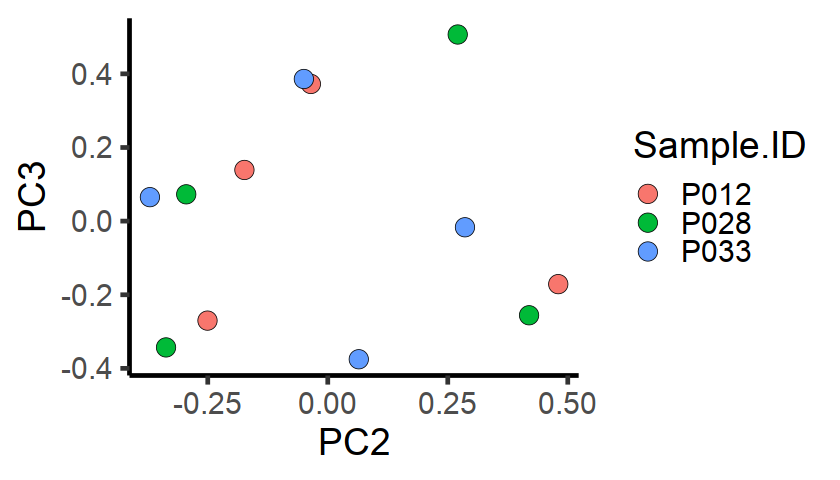

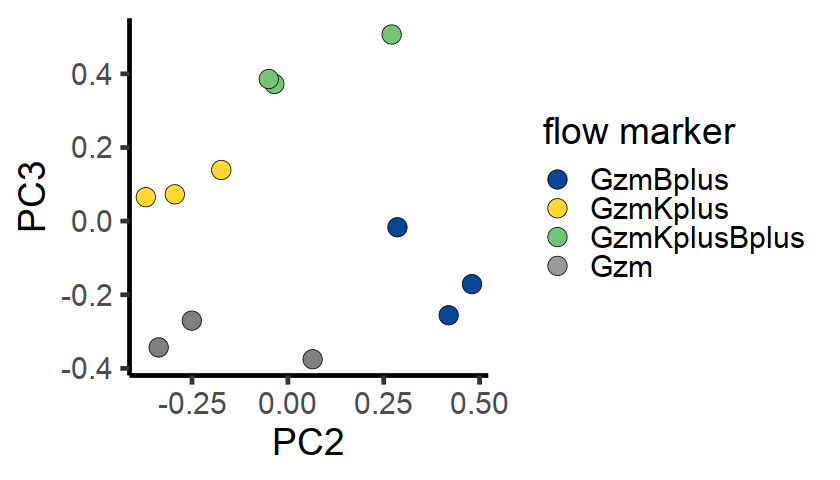

In [15]:
# Plot PCA results
options(repr.plot.height = 4, repr.plot.width = 7)
ggplot() +
  geom_point(
    data = meta,
    mapping = aes(PC2, PC3, fill = Sample.ID),
    shape = 21, size = 5, stroke = 0.25
  ) +
  theme_classic(base_size = 22) 
# ggsave("bulk_pca_donor.pdf", width = 4.5 , height = 3, dpi = 300)
# dev.off()

options(repr.plot.height = 4, repr.plot.width = 7)
ggplot() +
  geom_point(
    data = meta,
    mapping = aes(PC2, PC3, fill = marker),
    shape = 21, size = 5, stroke = 0.25
  ) +
  scale_fill_manual(values = meta_colors$marker, name = "flow marker") +
  theme_classic(base_size = 22) 
# ggsave("bulk_pca_marker.pdf", width = 7 , height = 4, dpi = 300)
# dev.off()

# Generate unbiased genes

In [18]:
library(presto)
meta$marker <- as.character(meta$marker)
table(meta$marker)

diff_genes <- wilcoxauc(log2tpm, meta$marker)
# x <- diff_genes %>%
#   group_by(group) %>%
#   top_n(20, wt = auc) 
x <- diff_genes[which(diff_genes$auc > 0.6 & diff_genes$logFC > 1.5),]


genes_exclude <- grep("^MT-|^RPL|^RPS|MALAT1|MIR-|LINC", row.names(log2tpm), value = TRUE)
x <- x[-which(x$feature %in% genes_exclude),]

In [19]:
gene_unbiased <- unique(x$feature)
gene_unbiased <- intersect(rownames(log2tpm), gene_unbiased)
gene_unbiased <- gene_unbiased[-1]
exp_unbiased <- log2tpm[gene_unbiased,]

In [156]:
length(gene_unbiased)
stat1 <- diff_genes[which(diff_genes$feature %in% gene_unbiased & diff_genes$auc > 0.6 & diff_genes$logFC > 1.2),]
dim(stat1)

stat2 <- diff_genes[which( (diff_genes$feature %in% setdiff(rownames(exp_unbiased_scale), stat1$feature)) & diff_genes$logFC > 0),]
dim(stat2)
stat2 <- stat2[order(stat2$feature, -abs(stat2$logFC)), ]
stat2 <- stat2[ !duplicated(stat2$feature), ]  
dim(stat2)

stat <- rbind(stat1, stat2)
stat <- stat[order(stat$group),]
write.table(stat, file = paste("bulk_heatmap_unbaised_list", ".txt", sep = ""),
            row.names=T,col.names=T, quote = F, sep = "\t")

[1] 99

[1] 99 10

[1] 40 10

[1] 20 10

# Load curated gene lists

In [92]:
genes <- read.delim("/data/srlab/fzhang/amp/results/2019_04_04_analyze_Helena_CD8_bulk_samples/200104_Draft_heat_map_gene_list.txt", header = T, stringsAsFactors = F)
genes <- as.character(t(genes))
genes <- c(genes, c("B3GAT1", "CD69", "LILRB1", "NR4A1", "GNLY", "STAT4"))
genes <- genes[-which(genes %in% c("TNFRSF1A", "TNFRSF1B"))]
genes <- unique(genes)
length(genes)

# genes %in% rownames(log2tpm)

exp_plot <- log2tpm[genes,]
exp_plot <- exp_plot[!duplicated(rownames(exp_plot)),]
dim(exp_plot)

[1] 45

[1] 45 12

## Visualize per sample level 

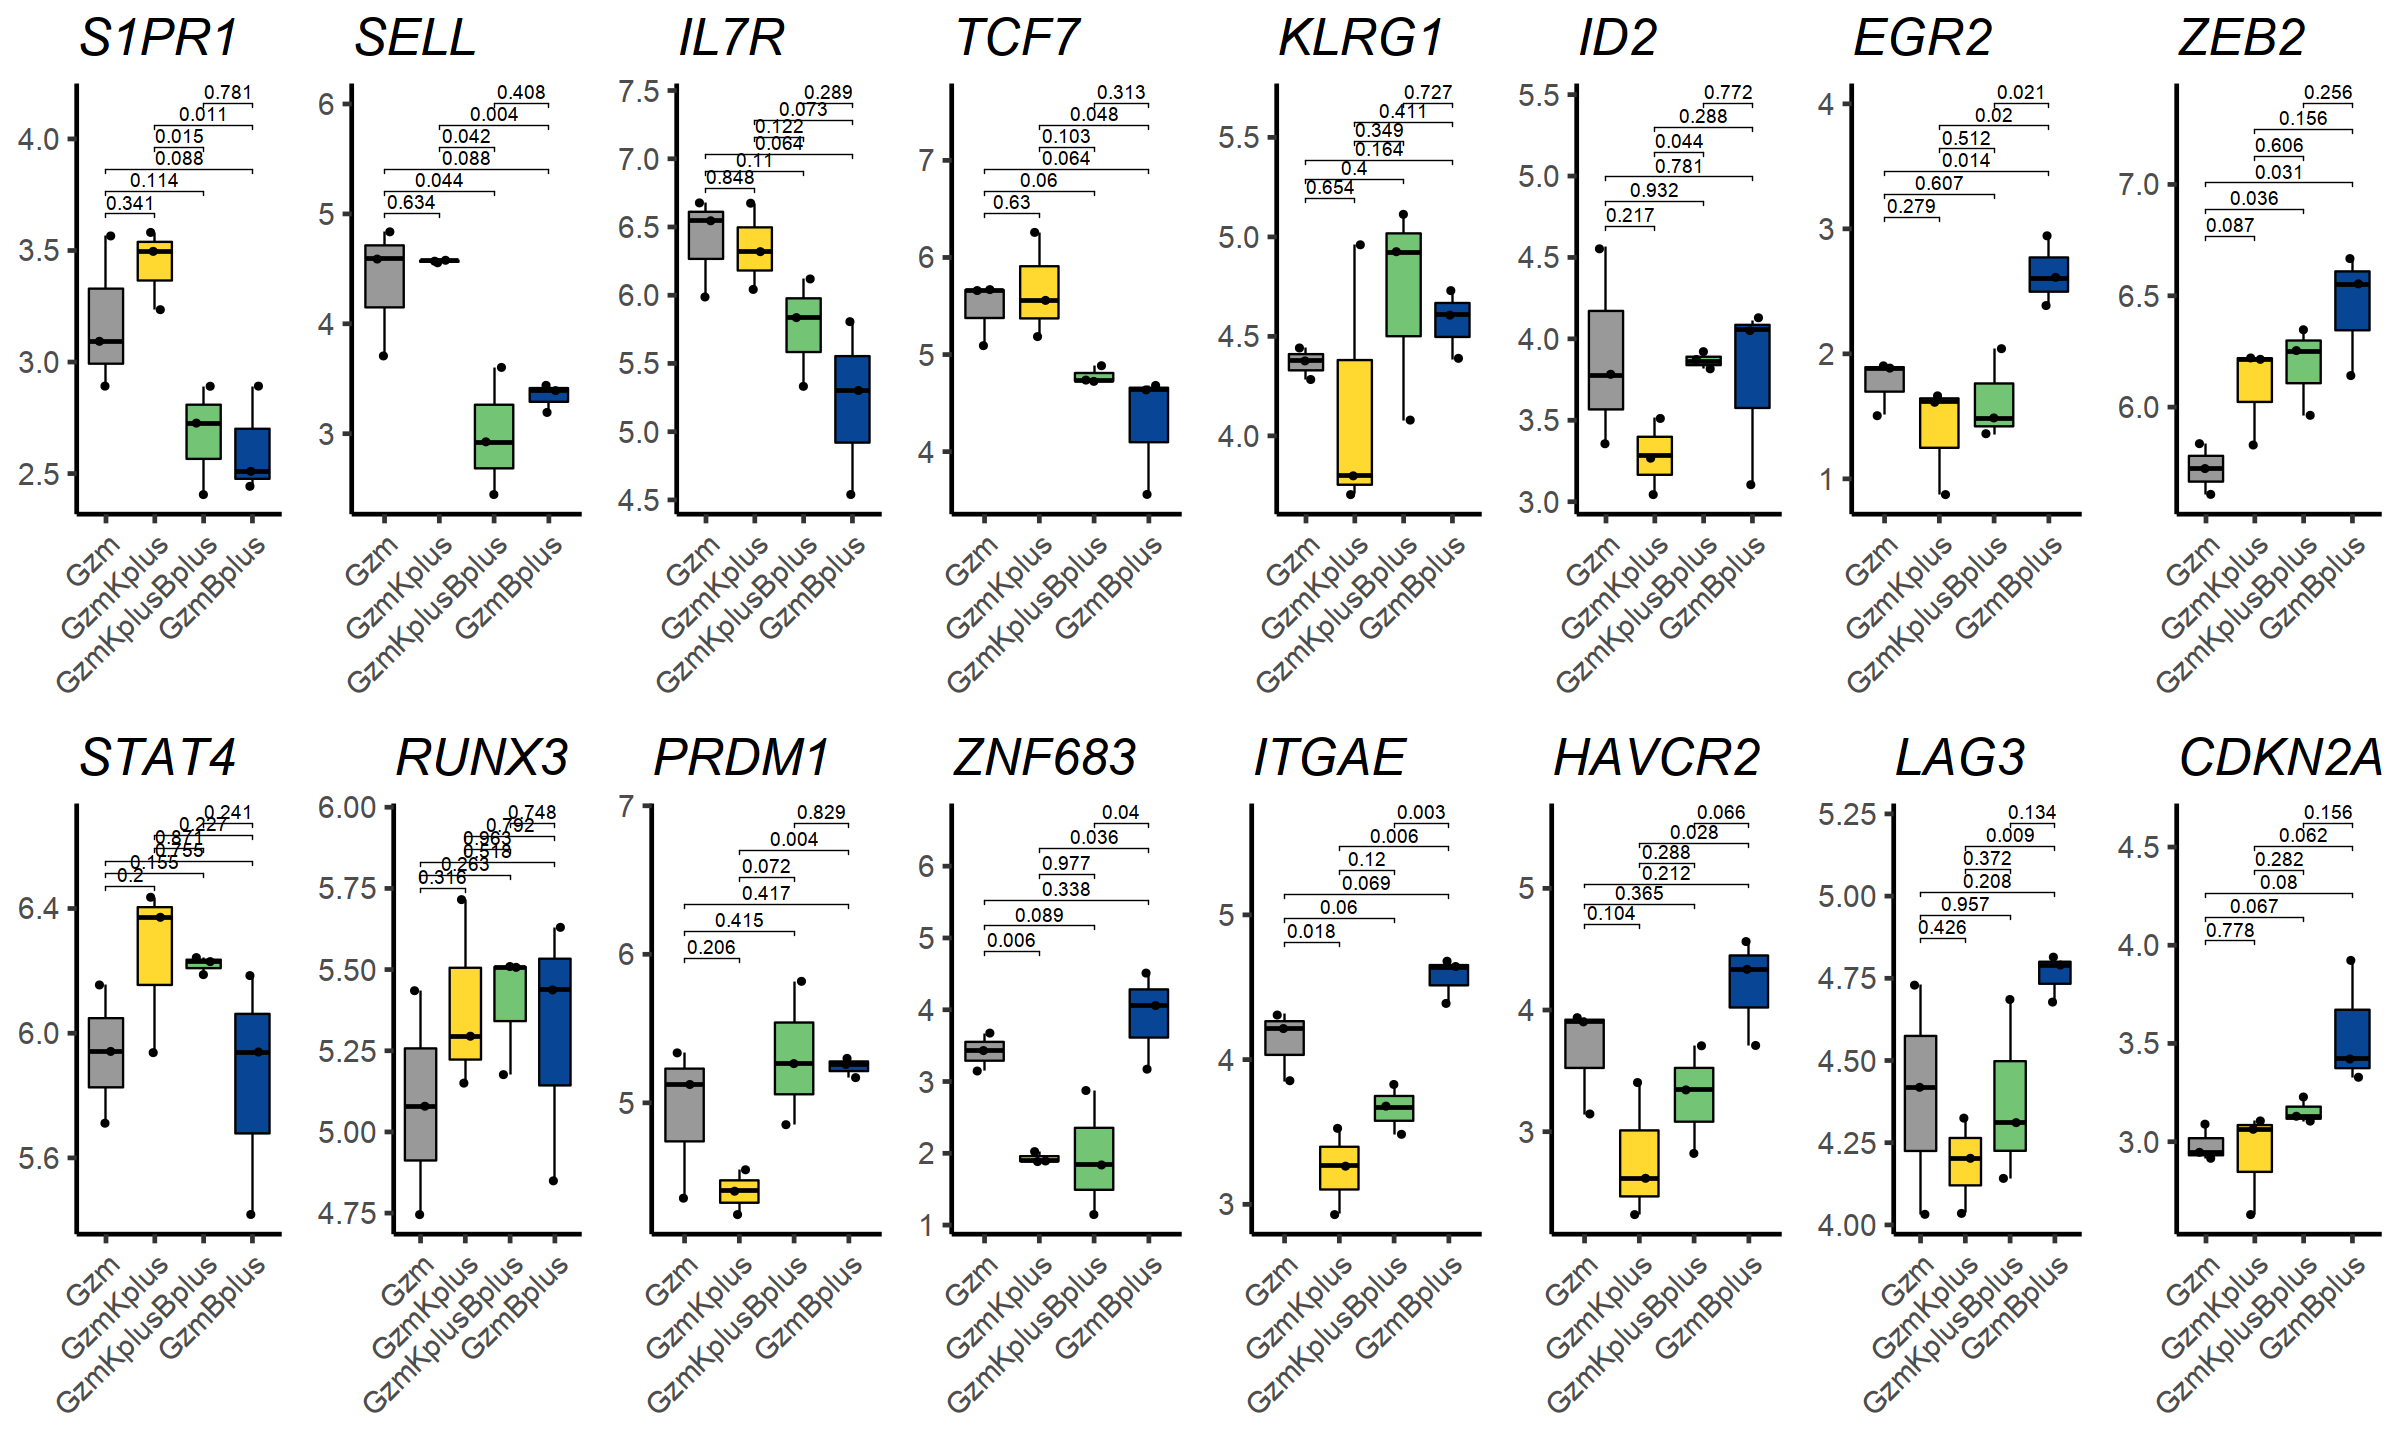

In [84]:
gene_plot <- c("S1PR1", "SELL", "IL7R", "TCF7", "KLRG1", "ID2", "EGR2", "ZEB2", "STAT4", "RUNX3", "PRDM1", "ZNF683", "ITGAE", "HAVCR2", "LAG3", "CDKN2A")

myplots <- list()
for (i in 1:length(gene_plot)) {
    gene <- gene_plot[i]
    meta$gene <- as.numeric(exp_plot[gene,])    

    stat.test <- meta %>% t_test(gene ~ marker, paired = FALSE) # t_test
    stat.test <- stat.test %>% add_xy_position(x = "marker")
    
   ind <- paste("p", i, sep = "")
   ind <- ggboxplot(meta, x = "marker", y = "gene", fill = "marker") +  geom_jitter(width = 0.15)  +  
            scale_fill_manual(values = meta_color$marker, name = "flow marker") +
            labs(
              x     = NULL,
              y     = NULL,
              title = gene
              ) +
              theme_classic(base_size = 22) + 
              theme(
              legend.position = "none",
              legend.key.size = unit(1.5, "lines"),
              axis.text.x = element_text(angle = 45, hjust = 1),
              plot.title      = element_text(size = 30, face = "italic")
            ) +
           stat_pvalue_manual(stat.test, label = "p", tip.length = 0.01)
    
   myplots[[i]] <- ind

}

options(repr.plot.height = 12, repr.plot.width = 20)
p <- do.call("grid.arrange", c(myplots, ncol = 8))
ggsave("bulk_gene_gzm.pdf", width = 20, p, height = 12, dpi = 300)


In [23]:
meta$marker_new <- as.character(meta$marker)
meta$marker_new[which(meta$marker_new %in% c("Gzm", "GzmKplus"))] <- "Gzm- and GzmKplus"
meta$marker_new <- factor(meta$marker_new, levels = c("Gzm- and GzmKplus", "GzmKplusBplus", "GzmBplus"))

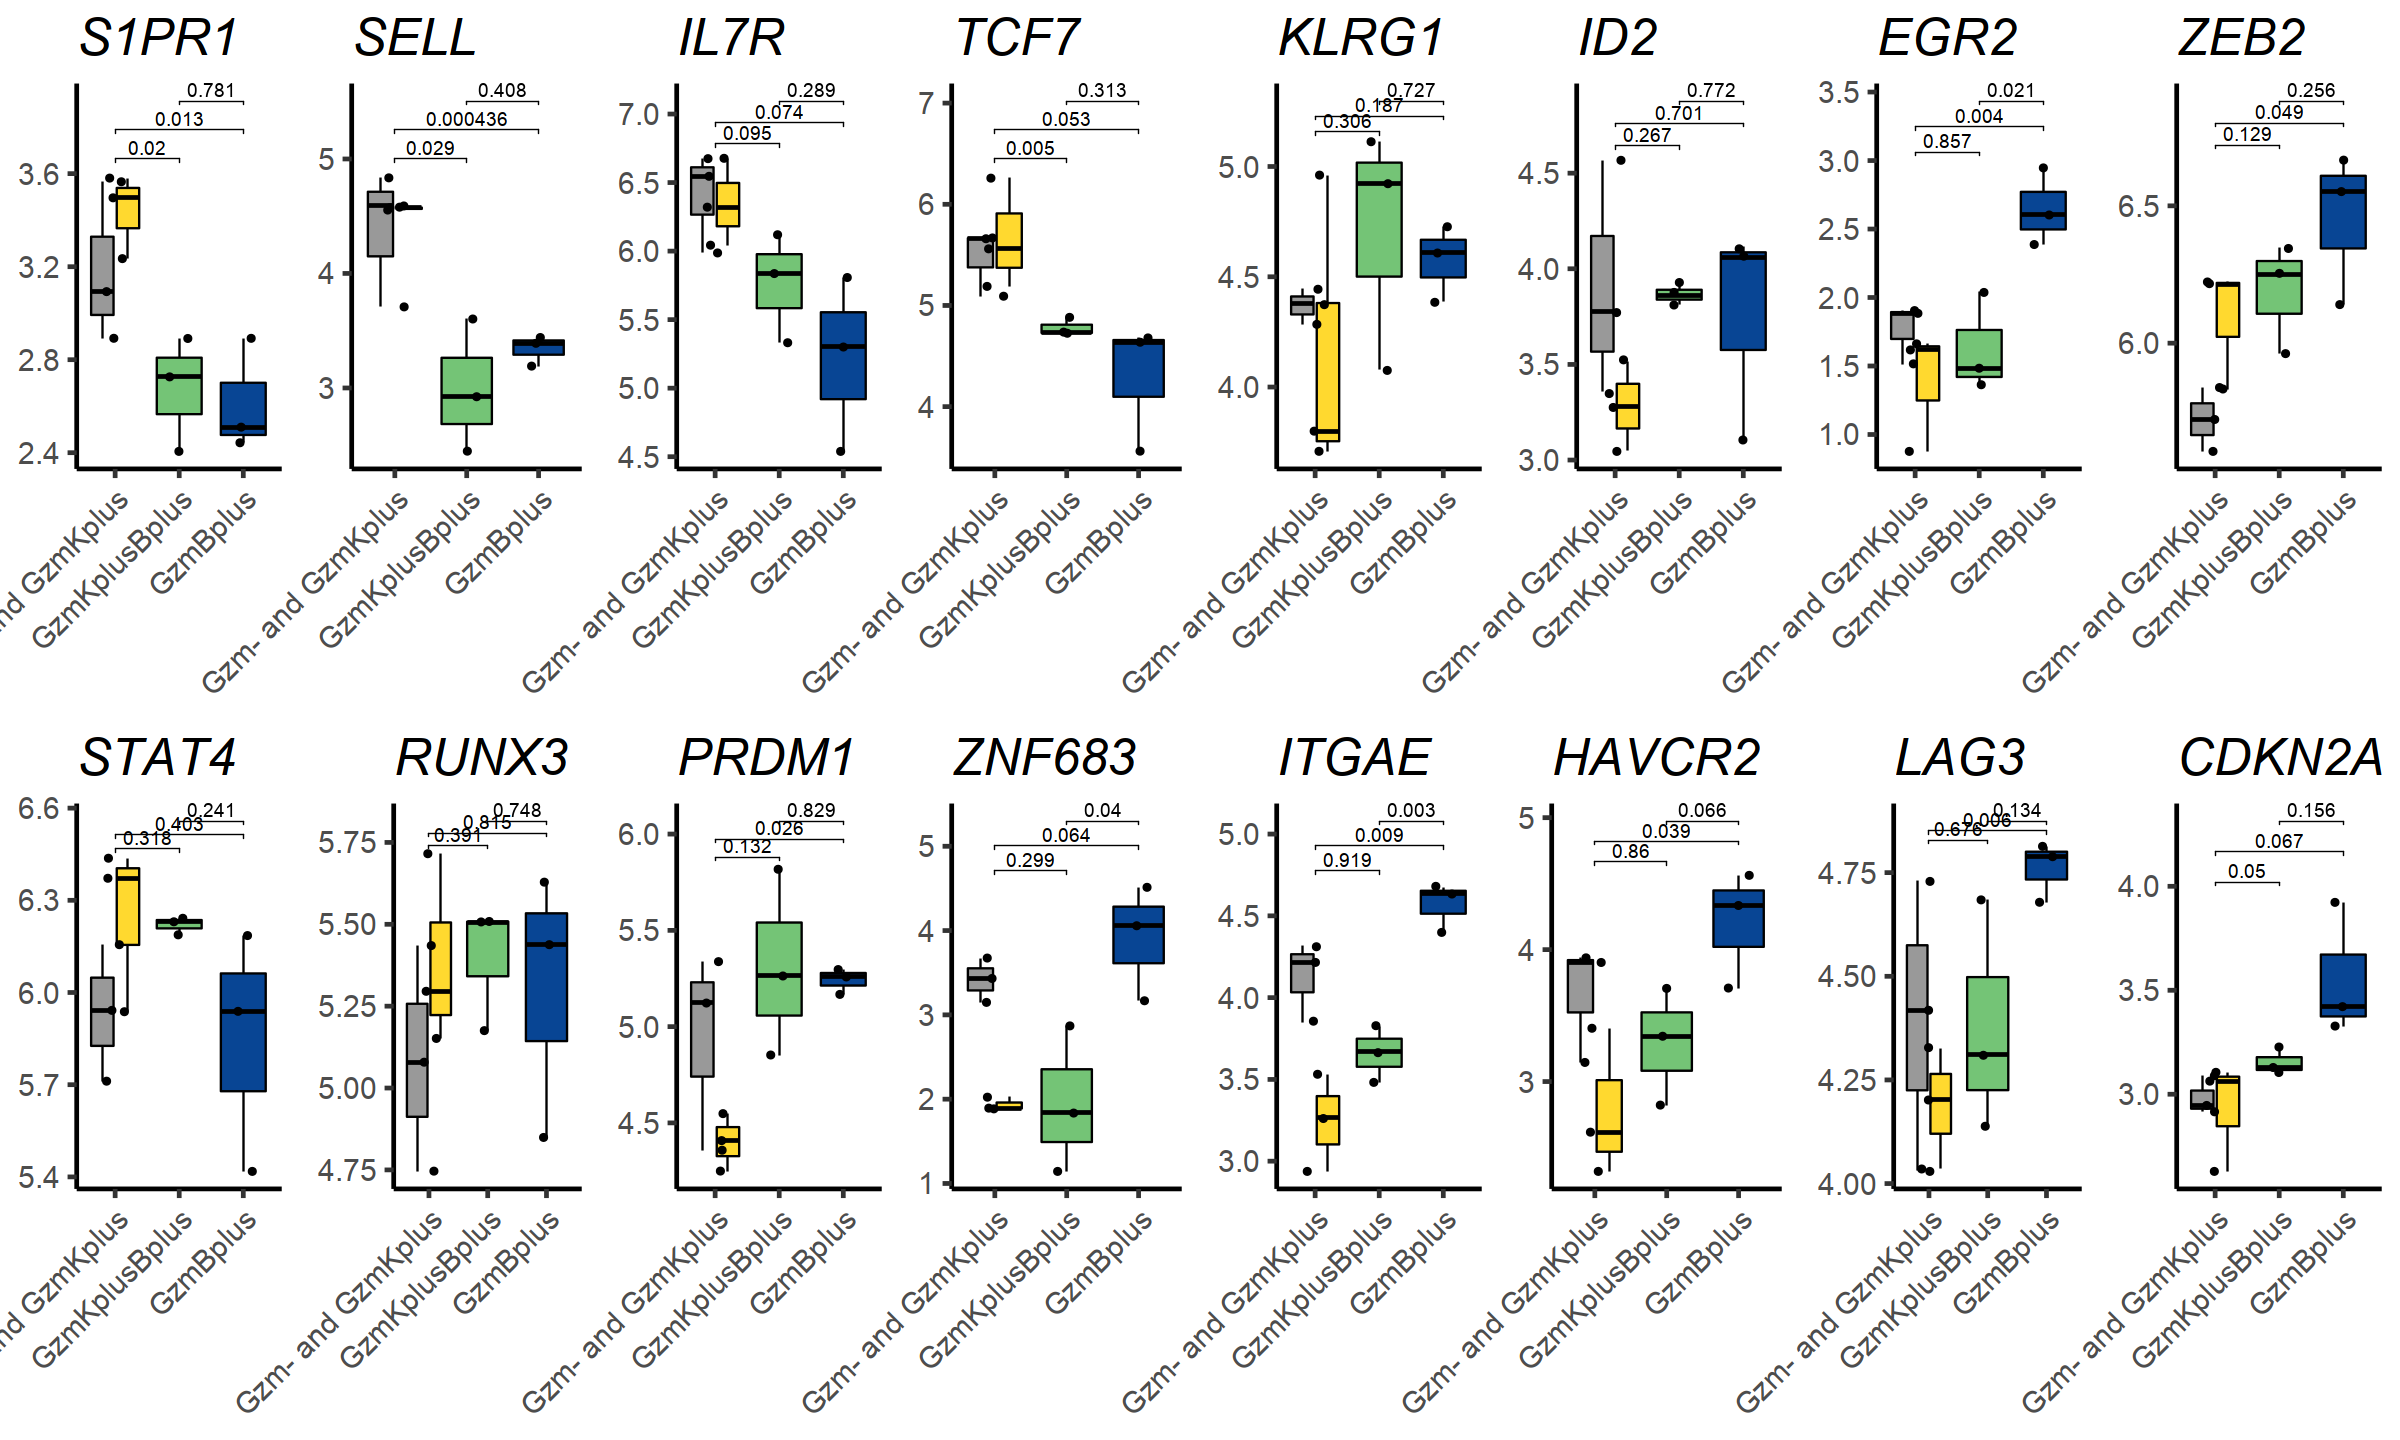

In [40]:
gene_plot <- c("S1PR1", "SELL", "IL7R", "TCF7", "KLRG1", "ID2", "EGR2", "ZEB2", "STAT4", "RUNX3", "PRDM1", "ZNF683", "ITGAE", "HAVCR2", "LAG3", "CDKN2A")

myplots <- list()
for (i in 1:length(gene_plot)) {
    gene <- gene_plot[i]
    meta$gene <- as.numeric(log2tpm[gene,])    

    stat.test <- meta %>% t_test(gene ~ marker_new, paired = FALSE, alternative = "two.sided") # t_test
    stat.test <- stat.test %>% add_xy_position(x = "marker_new")
    
   ind <- paste("p", i, sep = "")
   ind <- ggboxplot(meta, x = "marker_new", y = "gene", fill = "marker") +  geom_jitter(width = 0.15)  +  
            scale_fill_manual(values = meta_colors$marker, name = "flow marker") +
            labs(
              x     = NULL,
              y     = NULL,
              title = gene
              ) +
              theme_classic(base_size = 22) + 
              theme(
              legend.position = "none",
              legend.key.size = unit(1.5, "lines"),
              axis.text.x = element_text(angle = 45, hjust = 1),
              plot.title      = element_text(size = 30, face = "italic")
            ) +
           stat_pvalue_manual(stat.test, label = "p", tip.length = 0.01)
    
   myplots[[i]] <- ind

}

options(repr.plot.height = 12, repr.plot.width = 20)
p <- do.call("grid.arrange", c(myplots, ncol = 8))
ggsave("bulk_gene_gzm_version2.pdf", width = 20, p, height = 12, dpi = 300)


Warning message in rm(exp_plot_scale):
“object 'exp_plot_scale' not found”


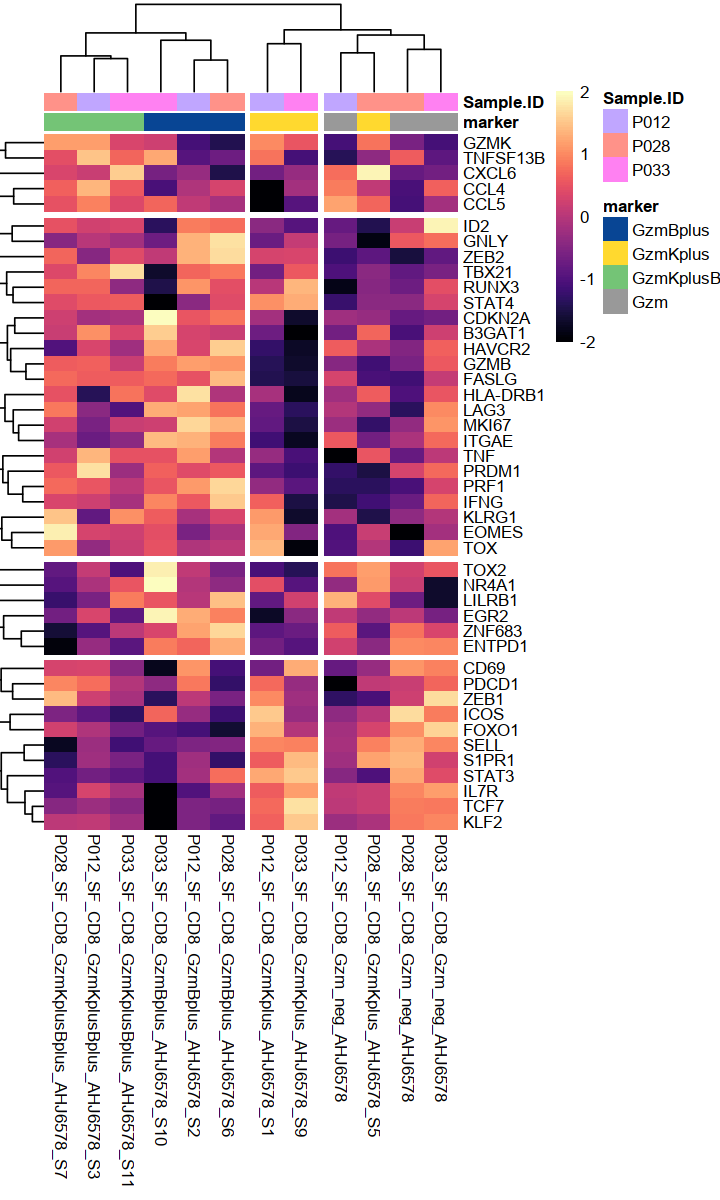

png 
  2

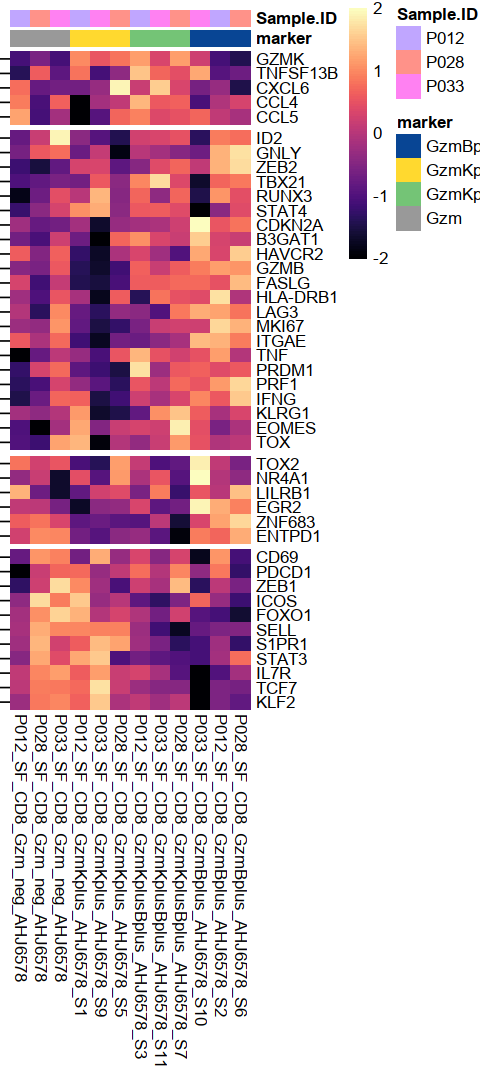

In [25]:
mat_breaks <- seq(min(exp_plot), max(exp_plot), length.out = 10)
quantile_breaks <- function(xs, n = 10) {
  breaks <- quantile(xs, probs = seq(0, 1, length.out = n))
  breaks[!duplicated(breaks)]
}
# mat_breaks <- quantile_breaks(exp_plot, n = 7)

annotation_col <- data.frame(
    key = colnames(exp_plot),
    marker = as.character(meta$marker),
    Sample.ID = as.character(meta$Sample.ID)
)
rownames(annotation_col) <- annotation_col$key
annotation_col <- annotation_col[, -1]
# exp_plot <- exp_plot[, order(annotation_col$marker)]


scale_rows <- function(x) t(scale(t(x)))
rm(exp_plot_scale)
exp_plot_scale <- scale_rows(exp_plot) # Z-score
exp_plot_scale[exp_plot_scale > 2] <- 2
exp_plot_scale[exp_plot_scale < -2] <- -2
exp_plot_scale <- na.omit(exp_plot_scale)
# exp_plot_scale <- exp_plot_scale[, order(annotation_col$marker)]

options(repr.plot.width = 6, repr.plot.height = 10)
# library(pheatmap)
out <- pheatmap(
  mat = exp_plot_scale,
  border_color = NA,
#   breaks  = mat_breaks,
  color  = magma(100),
  show_rownames = T,
  show_colnames = T,
  annotation_col = annotation_col, 
  annotation_colors = meta_color,
  cluster_rows = TRUE,
  cluster_cols = TRUE,
  cellwidth = 20,
  cutree_rows = 4,
  cutree_cols = 3,
  fontsize = 10,
  fontsize_row = 10
#   scale = "none"
)
# dev.off()

# Adjust the column sample order
col_order <- colnames(exp_plot_scale[,out$tree_col[["order"]]])
col_order <- c('P012_SF_CD8_Gzm_neg_AHJ6578', 'P028_SF_CD8_Gzm_neg_AHJ6578', 'P033_SF_CD8_Gzm_neg_AHJ6578',
               'P012_SF_CD8_GzmKplus_AHJ6578_S1','P033_SF_CD8_GzmKplus_AHJ6578_S9', 'P028_SF_CD8_GzmKplus_AHJ6578_S5', 
               'P012_SF_CD8_GzmKplusBplus_AHJ6578_S3', 'P033_SF_CD8_GzmKplusBplus_AHJ6578_S11', 'P028_SF_CD8_GzmKplusBplus_AHJ6578_S7', 
               'P033_SF_CD8_GzmBplus_AHJ6578_S10', 'P012_SF_CD8_GzmBplus_AHJ6578_S2', 'P028_SF_CD8_GzmBplus_AHJ6578_S6'
              )
# col_order <- replace(col_order, c(9, 10), col_order[c(10, 9)])
exp_plot_scale <- exp_plot_scale[, match(col_order, colnames(exp_plot_scale))]

options(repr.plot.width = 4, repr.plot.height = 9)
out <- pheatmap(
  mat = exp_plot_scale,
  border_color = NA,
#   breaks  = mat_breaks,
  color  = magma(100),
  show_rownames = T,
  show_colnames = T,
  annotation_col = annotation_col, 
  annotation_colors = meta_color,
  cluster_rows = TRUE,
  cluster_cols = FALSE,
  cellwidth = 12,
  cutree_rows = 4,
  cutree_cols = 3,
  fontsize = 10,
  fontsize_row = 10,
  legend = TRUE
#   scale = "none"
)

save_pheatmap_pdf <- function(x, filename, width=4, height=9) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   pdf(filename, width=width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   dev.off()
}
save_pheatmap_pdf(out, "bulk_heatmap1.pdf")

## Plot receptor ligand

[1] TRUE

[1] 268

[1] 48 10

[1] 47 12

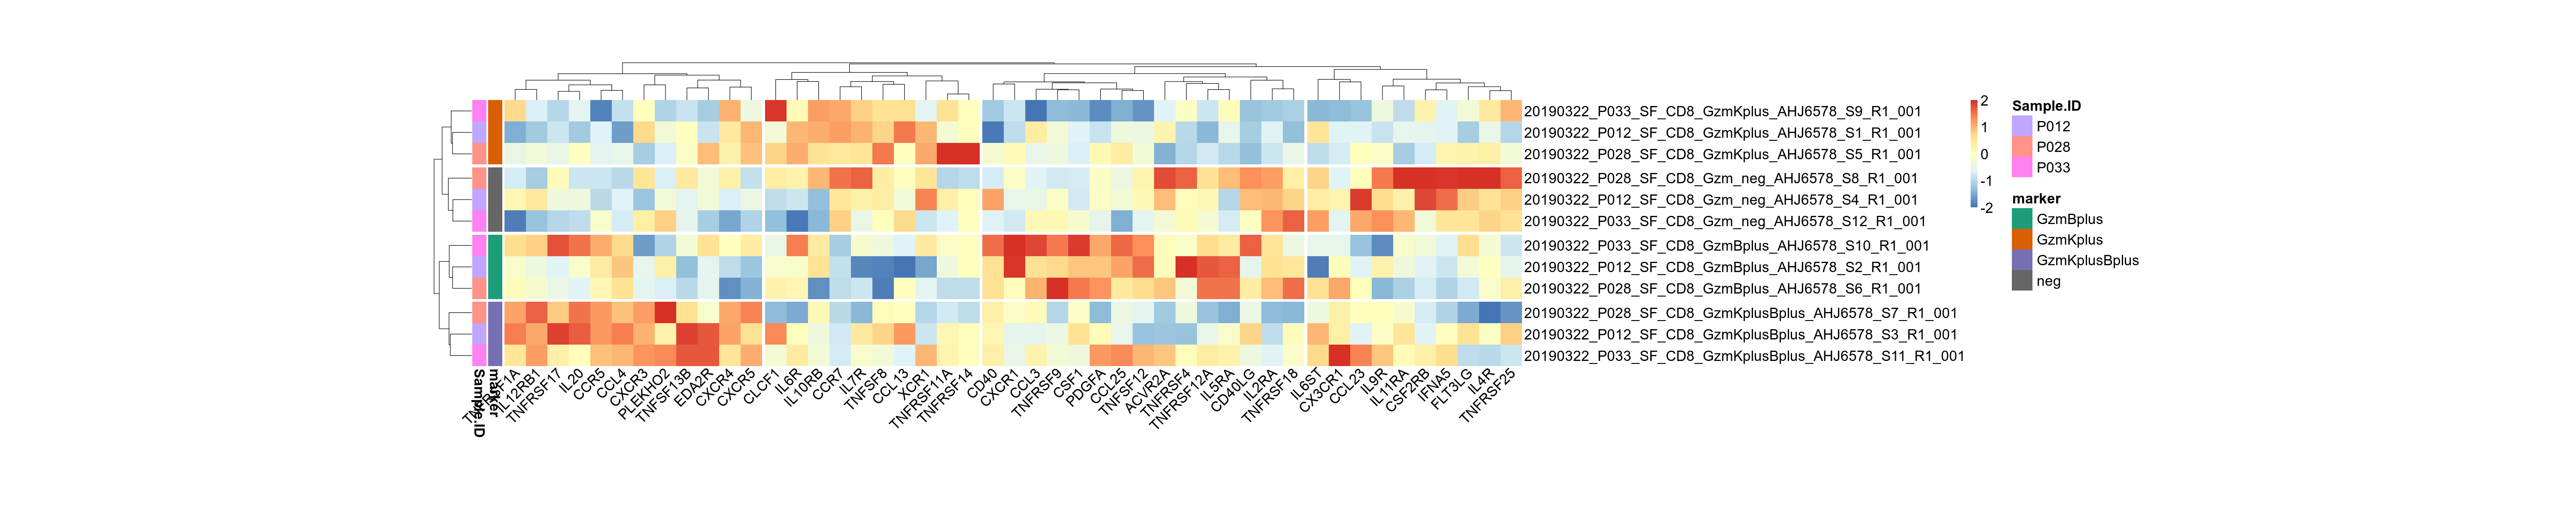

In [509]:
# Convert TPM to log2(TPM+1)
# bulk$abundance is TPM
tpm_to_log2tpm <- function(x) log(x + 1)
log2tpm <- apply(as.data.frame(bulk$abundance), 2, tpm_to_log2tpm)

# Add gene names
# genes <- readr::read_tsv("/data/srlab/public/srcollab/AMP/amp_phase1_ra/validation_data/Homo_sapiens.GRCh38.cdna.lincrna.filtered.genes.tsv.gz")
genes <- read.delim("/data/srlab/public/srcollab/AMP/amp_phase1_ra/validation_data/Homo_sapiens.GRCh38.cdna.lincrna.filtered.genes.tsv.gz", header = T, stringsAsFactors = F)
genes <- genes[!duplicated(genes$gene_id), ]
genes <- genes[which(genes$gene_id %in% rownames(log2tpm)),]

all(rownames(log2tpm) == genes$gene_id)
rownames(log2tpm) <- genes$hgnc_symbol
log2tpm <- removeBatchEffect(x = log2tpm, batch = as.character(meta$Sample.ID))



# Read txt file
effector <- read.table("M9809_KEGG_Cytokine_Cytokine_Receptor_Interaction_gene_list.txt", header = T, stringsAsFactors = F, sep = "\t")
effector <- as.character(t(effector))
length(effector)



# Select most distinct TFs to show
diff_genes <- wilcoxauc(log2tpm, meta$marker)
x <- diff_genes %>%
  group_by(group) %>%
  top_n(1000, wt = auc) 

dim(x[which(x$feature %in% effector),])

# Instead of showing all the TFs, only show diff expressed TF across the Gzm groups
exp_effector <- log2tpm[which(rownames(log2tpm) %in% x[which(x$feature %in% effector),]$feature),]
# exp_tf <- log2tpm[which(rownames(log2tpm) %in% union(lambert_tf, ravasi_tf)),]
exp_effector <- na.omit(exp_effector)
dim(exp_effector)

mat_breaks <- seq(min(exp_effector), max(exp_effector), length.out = 10)
quantile_breaks <- function(xs, n = 10) {
  breaks <- quantile(xs, probs = seq(0, 1, length.out = n))
  breaks[!duplicated(breaks)]
}
# mat_breaks <- quantile_breaks(exp_plot, n = 7)

annotation_col <- data.frame(
    key = colnames(exp_effector),
    marker = as.character(meta$marker),
    Sample.ID = as.character(meta$Sample.ID)
)
rownames(annotation_col) <- annotation_col$key
annotation_col <- annotation_col[, -1]
# exp_plot <- exp_plot[, order(annotation_col$marker)]


scale_rows <- function(x) t(scale(t(x)))
exp_effector_scale <- scale_rows(exp_effector) # Z-score
exp_effector_scale[exp_effector_scale > 2] <- 2
exp_effector_scale[exp_effector_scale < -2] <- -2
# Remove the nan value rows
exp_effector_scale <- na.omit(exp_effector_scale)
exp_effector_scale <- as.matrix(t(exp_effector_scale))

options(repr.plot.width = 50, repr.plot.height = 10)
# library(pheatmap)
pheatmap(
  mat = exp_effector_scale,
  border_color = NA,
#   breaks  = mat_breaks,
#   color  = viridis(100),
  show_rownames = T,
  show_colnames = T,
  annotation_row = annotation_col, 
  annotation_colors = meta_color,
  cluster_rows = TRUE,
  cluster_cols = TRUE,
  cellwidth = 30,
  cellheight = 30,
  cutree_rows = 4,
  cutree_cols = 4,
  fontsize = 20,
  fontsize_row = 20
#   scale = "none"
)